<h1 style="text-align: center; color: darkblue;">
    The effect of tourism on housing affordability in Spain
</h1>

Thousands of people have recently protested against tourism in different parts of Spain. One of the main claims is that the large amount of tourism in the region makes it harder and more expensive to rent or buy a house. The claim is supported by saying that it's more profitable to rent out by the day to tourists than long-term to citizens. Moreover, they claim that many tourists with higher incomes than locals buy houses in the regions they visit, making house prices rise. A different opinion is that tourism stimulates the economy, with more jobs in the industry and increased salaries.

<div style="display: flex; flex-direction: row; gap: 10px;">
  <div>
    <img src="https://static.euronews.com/articles/stories/08/39/05/38/1920x1080_cmsv2_786f35cd-adef-59c3-9471-915317aeace6-8390538.jpg" alt="A protest against tourism, with a banner that says 'Tourists go home' " width="350"/>
  </div>
  <div>
    <img src="https://img2.rtve.es/i/?w=1600&i=01716770794275.jpg" alt="A protest against tourism in the Canary islands, with a banner that says 'Foreigners buy 1 in every 3 houses, where are we going to live?' " width="350"/>
  </div>
  <div>
    <img src="https://www.usnews.com/object/image/0000018f-b14f-de9d-a5af-f5cf6c5f0000/tag%3Areuters.com%2C2024%3Anewsml_LYNXMPEK4O08Z%3A12024-05-25T195033Z_1_LYNXMPEK4O08Z_RTROPTP_3_SPAIN-TOURISM-PROTEST.JPG?update-time=1716675777000&size=responsive970" alt="A protest against tourism in Palma with abanner saying 'Mallorca is not for sale' " width="295"/>
  </div>v>
v>
"300"/>

Motivated by this, in this project, we'll investigate if there is a correlation between tourism and housing (and renting) affordability. 

We measure housing affordability with the average number of years the average citizen would need to buy the avarage house, and we call this the housing affordability index (HAI). That is, the HAI of a region is calculated as follows:
$$\text{HAI of a region}=\frac{\text{Average price of a house in the region}}{\text{Average yearly income in the region}}$$

We measure renting affordability with the percentage of an average income that would have to be spent on renting a 40-sqm living and we call this the RAI. That is, the RAI of a region is calculated as follows:
$$\text{RAI of a region}=\frac{\text{Average monthly rent price for a 40-sqm living in the region}}{\text{Average monthly income in the region}}\times 100$$
Notice this is not an actual representation of what percentage of the salary is actually spent on rent. However, the RAI is useful to compare prices w.r.t. salaries in different regions.

We measure the amount of tourism with the number of tourists that visit a region over the number of residents in that region.

The questions we aim to answer are:
* Is there a correlation between the amount of tourism and the HAI?
* Is there a correlation between the amount of tourism and the RAI?

To investigate these questions, we compare different regions with different amounts of tourism and see how they affect the HAI and RAI. Another approach could be to see how different amounts of tourism in a region across time affect the HAI and RAI, but we don't take this approach here. 

# 1. Data Collection

We will start by collect the following data:
* Number of tourists and number of residents per region
* HAI per region
* Average price to rent per square meter and average monthly salary per region
* Geojson with the map ofdata

In [2]:
%%capture
!pip install requests beautifulsoup4 pandas geopandas folium matplotlib plotly scikit-learn

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

## Number of tourists and residents data

We start by reading the csv files containing the number of tourists and residents per Spanish region. These files have delimiter ";" and can be found here:

* https://www.ine.es/jaxi/Tabla.htm?path=/t20/p274/serie/prov/p05/l0/&file=03001.px&L=0 (residents)
* https://www.ine.es/jaxiT3/Tabla.htm?t=23988&L=0 (tourists)

In [4]:
df2 = pd.read_csv('23988.csv', delimiter=';', encoding='latin1') 
df1 = pd.read_csv('03001.csv', delimiter=';', encoding='latin1')  

We check that this worked.

In [5]:
df1.head()

,Total Nacional,Comunidades y Ciudades Autónomas,Estado civil,Sexo,Grupo de edad,periodo,Total
0,Total Nacional,NaN,Total (estado civil),Ambos sexos,Total (grupo de edad),2018,"46.248,3"
1,Total Nacional,Andalucía,Total (estado civil),Ambos sexos,Total (grupo de edad),2018,"8.345,0"
2,Total Nacional,Aragón,Total (estado civil),Ambos sexos,Total (grupo de edad),2018,"1.292,0"
3,Total Nacional,"Asturias, Principado de",Total (estado civil),Ambos sexos,Total (grupo de edad),2018,"1.013,3"
4,Total Nacional,"Balears, Illes",Total (estado civil),Ambos sexos,Total (grupo de edad),2018,"1.169,1"


In [6]:
df2.head()

,Comunidades autónomas,Tipo de dato,Periodo,Total
0,Total,Dato base,2018,82.808.413
1,01 Andalucía,Dato base,2018,11.681.256
2,02 Aragón,Dato base,2018,545.530
3,"03 Asturias, Principado de",Dato base,2018,299.357
4,"04 Balears, Illes",Dato base,2018,13.851.598


Notice that the data in the tables is from 2018. This is the most recent year for which there was data which wasn't affected by the COVID-19 pandemic. 

## HAI data

We now load the data of how long it takes to buy a house per region, which can be found here:

https://es.statista.com/estadisticas/544760/indice-de-esfuerzo-para-comprar-una-vivienda-en-espana-por-cc-aa/

In [7]:
url = 'https://es.statista.com/estadisticas/544760/indice-de-esfuerzo-para-comprar-una-vivienda-en-espana-por-cc-aa/'

We get the HTML content from the specified URL.

In [8]:
response = requests.get(url)

We convert the content into a BeautifulSoup object

In [9]:
soup = BeautifulSoup(response.content, 'html.parser')

We find the first table in the HTML.

In [10]:
table = soup.find('table')

We store the table headers in a list 'headers'.

In [11]:
headers = []
for th in table.find_all('th'):
    headers.append(th.text.strip())

We store the text from all text from non-empty cells in a list 'rows'.

In [12]:
rows = []
for tr in table.find_all('tr'):
    cells = tr.find_all('td')
    row = [cell.text.strip() for cell in cells]
    if row:  #if row is empty it won't be appended
        rows.append(row)

We convert the list of rows with headers into a dataframe.

In [13]:
df3 = pd.DataFrame(rows, columns=headers)
df3.head()

,Característica,Índice de esfuerzo inmobiliario
0,Islas Baleares,"19,9"
1,C. de Madrid,"9,3"
2,Cataluña,"8,6"
3,Media nacional,"7,6"
4,Galicia,"7,5"


## Average price to rent per square meter and average monthly salary per region


We now get the data of rent prices, which can be found here:

https://www.idealista.com/sala-de-prensa/informes-precio-vivienda/alquiler/.

In [14]:
df5 = pd.read_csv('rent.csv', delimiter=';', encoding='latin1')
df5

,Localización,Precio m2 jul 2024,Variación mensual,Variación trimestral,Variación anual,Máximo histórico,Variación máximo
0,España,"13,1 /m2","- 1,6 %","+ 1,3 %","+ 10,4 %","13,4 /m2 jun 2024","- 1,6 %"
1,Andalucía,"11,4 /m2","- 0,8 %","+ 0,9 %","+ 11,0 %","11,5 /m2 jun 2024","- 0,8 %"
2,Aragón,"9,3 /m2","+ 1,2 %","+ 4,7 %","+ 8,8 %","9,3 /m2 jul 2024","0,0 %"
3,Asturias,"9,0 /m2","+ 0,4 %","+ 4,1 %","+ 10,4 %","12,5 /m2 feb 2008","- 27,8 %"
4,Baleares,"18,9 /m2","- 5,1 %","+ 6,2 %","+ 14,6 %","19,9 /m2 jun 2024","- 5,1 %"
5,Canarias,"13,9 /m2","- 1,9 %","+ 2,2 %","+ 9,7 %","14,2 /m2 jun 2024","- 1,9 %"
6,Cantabria,"11,5 /m2","- 2,9 %","+ 6,8 %","+ 8,1 %","14,8 /m2 jul 2007","- 22,0 %"
7,Castilla y León,"8,2 /m2","0,0 %","+ 1,9 %","+ 8,1 %","8,2 /m2 jun 2024","0,0 %"
8,Castilla-La Mancha,"7,1 /m2","+ 0,5 %","+ 1,7 %","+ 8,3 %","7,1 /m2 jul 2024","0,0 %"
9,Cataluña,"16,7 /m2","- 3,6 %","- 0,6 %","+ 9,4 %","17,4 /m2 jun 2024","- 3,6 %"


We also collect the data of avarage salaries, which can be found here:

https://www.ine.es/jaxiT3/Tabla.htm?t=13930&L=0.

In [15]:
df6 = pd.read_csv('salary.csv', delimiter=';', encoding='latin1')
df6.head()

,Tipo de jornada,Comunidades y Ciudades Autonómas,Decil,Periodo,Total
0,Total,Total Nacional,Total decil,2022,"2.128,37"
1,Total,01 Andalucía,Total decil,2022,"1.914,87"
2,Total,02 Aragón,Total decil,2022,"2.029,96"
3,Total,"03 Asturias, Principado de",Total decil,2022,"2.115,30"
4,Total,"04 Balears, Illes",Total decil,2022,"2.311,67"


## Map data

Finally, we load GeoJSON file so we can plot our data in maps with regions limits later. This file can be found here:

https://hub.arcgis.com/datasets/e75892d1a49646d8a29705ac6680f981_0/about.

In [16]:
import geopandas as gpd

#we had to split CCAA.geojson into 3 parts to be able to upload it to github
gdf_part1 = gpd.read_file('split_geojson_files/part_1.geojson')
gdf_part2 = gpd.read_file('split_geojson_files/part_2.geojson')
gdf_part3 = gpd.read_file('split_geojson_files/part_3.geojson')

#we combine the 3 dataframes
json_df = gpd.GeoDataFrame(pd.concat([gdf_part1, gdf_part2, gdf_part3], ignore_index=True))
json_df.head()

,OBJECTID,INSPIREID,COUNTRY,NATLEV,NATLEVNAME,NATCODE,NAMEUNIT,CODNUT1,CODNUT2,CODNUT3,geometry
0,1,ES.IGN.BDDAE.34010000000,ES,https://inspire.ec.europa.eu/codelist/Administ...,Comunidad autónoma,34010000000,Andalucía,ES6,ES61,,"MULTIPOLYGON (((-6.3176 36.5288, -6.31759 36.5..."
1,2,ES.IGN.BDDAE.34020000000,ES,https://inspire.ec.europa.eu/codelist/Administ...,Comunidad autónoma,34020000000,Aragón,ES2,ES24,,"POLYGON ((-1.68752 40.57939, -1.68582 40.57991..."
2,3,ES.IGN.BDDAE.34030000000,ES,https://inspire.ec.europa.eu/codelist/Administ...,Comunidad autónoma,34030000000,Principado de Asturias,ES1,ES12,,"MULTIPOLYGON (((-6.85727 43.17325, -6.85767 43..."
3,4,ES.IGN.BDDAE.34040000000,ES,https://inspire.ec.europa.eu/codelist/Administ...,Comunidad autónoma,34040000000,Illes Balears,ES5,ES53,,"MULTIPOLYGON (((1.24355 38.86118, 1.2436 38.86..."
4,5,ES.IGN.BDDAE.34060000000,ES,https://inspire.ec.europa.eu/codelist/Administ...,Comunidad autónoma,34060000000,Cantabria,ES1,ES13,,"MULTIPOLYGON (((-4.15851 42.86621, -4.16084 42..."


# 2. Data cleaning

We now select the columns we are interested from each dataframe.

In [17]:
df1=df1[['Comunidades y Ciudades Autónomas', 'Total']]
df2=df2[['Comunidades autónomas','Total']]
df5=df5[['Localización', 'Precio m2 jul 2024']]
df6=df6[['Comunidades y Ciudades Autonómas', 'Total']]

We also change the labels so that the region header matches the header in the geojson file.

In [18]:
df1.columns=['NAMEUNIT', 'No of residents']
df2.columns= ['NAMEUNIT','No of tourists']
df3.columns=['NAMEUNIT', 'HAI']
df5.columns=['NAMEUNIT', 'Rent m2']
df6.columns=['NAMEUNIT', 'Monthly salary']

In [19]:
df1.head()

,NAMEUNIT,No of residents
0,NaN,"46.248,3"
1,Andalucía,"8.345,0"
2,Aragón,"1.292,0"
3,"Asturias, Principado de","1.013,3"
4,"Balears, Illes","1.169,1"


We can see that the column 'No of residents' has points to indicate thousands and commas to indicate decimals, as well as most other numeric columns do. Since this is not standard, we remove the points from all values, which are only for readability and replace commas by points. Then, we convert the data to float. We define a function to do all this.

In [20]:
def clean(df, column):
    df.loc[:,column] = df[column].str.replace('.', '').str.replace(',', '.').astype(float)

In [21]:
clean(df1,'No of residents')
clean(df2,'No of tourists')
clean(df3,'HAI')
clean(df6,'Monthly salary')

We remove '€/m2' from the 'Rent m2' columns in df5, and then we clean it.

In [22]:
df5.loc[:, 'Rent m2'] = df5['Rent m2'].str.replace(' /m2', '', regex=False)
clean(df5, 'Rent m2')

We remove the numbers from the region names in df2, which are the same as the region names in df1, but preceded by a number. 

In [23]:
df2['NAMEUNIT']=df2['NAMEUNIT'].replace(r'^\d+\s+', '', regex=True)

We remove the row corresponding to Spain as a whole from df3.

In [24]:
df3 = df3[df3['NAMEUNIT'] != 'Media nacional']

We replace the region names to match those in the geojson file.

In [25]:
replacement1 = {
    'Andalucía': 'Andalucía',
    'Aragón': 'Aragón',
    'Asturias, Principado de': 'Principado de Asturias',
    'Balears, Illes': 'Illes Balears',
    'Canarias': 'Canarias',
    'Cantabria': 'Cantabria',
    'Castilla y León': 'Castilla y León',
    'Castilla - La Mancha': 'Castilla-La Mancha',
    'Cataluña': 'Cataluña/Catalunya',
    'Comunitat Valenciana': 'Comunitat Valenciana',
    'Extremadura': 'Extremadura',
    'Galicia': 'Galicia',
    'Madrid, Comunidad de': 'Comunidad de Madrid',
    'Murcia, Región de': 'Región de Murcia',
    'Navarra, Comunidad Foral de': 'Comunidad Foral de Navarra',
    'País Vasco': 'País Vasco/Euskadi',
    'Rioja, La': 'La Rioja',
    'Ceuta': 'Ciudad Autónoma de Ceuta',
    'Melilla': 'Ciudad Autónoma de Melilla'
}

df1.loc[:,'NAMEUNIT'] = df1['NAMEUNIT'].replace(replacement1)
df2.loc[:,'NAMEUNIT'] = df2['NAMEUNIT'].replace(replacement1)

replacement3 = {
    'Islas Baleares': 'Illes Balears',
    'C. de Madrid': 'Comunidad de Madrid',
    'Cataluña': 'Cataluña/Catalunya',
    'Galicia': 'Galicia',
    'País Vasco': 'País Vasco/Euskadi',
    'Andalucía': 'Andalucía',
    'Canarias': 'Canarias',
    'Navarra': 'Comunidad Foral de Navarra',
    'C. Valenciana': 'Comunitat Valenciana',
    'Cantabria': 'Cantabria',
    'Extremadura': 'Extremadura',
    'Castilla y León': 'Castilla y León',
    'La Rioja': 'La Rioja',
    'Asturias': 'Principado de Asturias',
    'Aragón': 'Aragón',
    'Castilla-La Mancha': 'Castilla-La Mancha',
    'Región de Murcia': 'Región de Murcia'
}

df3['NAMEUNIT'] = df3['NAMEUNIT'].replace(replacement3)


replacement5 = {
    'Andalucía': 'Andalucía',
    'Aragón': 'Aragón',
    'Asturias': 'Principado de Asturias',
    'Baleares': 'Illes Balears',
    'Canarias': 'Canarias',
    'Cantabria': 'Cantabria',
    'Castilla y León': 'Castilla y León',
    'Castilla-La Mancha': 'Castilla-La Mancha',
    'Cataluña': 'Cataluña/Catalunya',
    'Comunitat Valenciana': 'Comunitat Valenciana',
    'Euskadi': 'País Vasco/Euskadi',
    'Extremadura': 'Extremadura',
    'Galicia': 'Galicia',
    'La Rioja': 'La Rioja',
    'Madrid Comunidad': 'Comunidad de Madrid',
    'Melilla': 'Melilla',
    'Murcia Región': 'Región de Murcia',
    'Navarra': 'Comunidad Foral de Navarra'
}
df5.loc[:, 'NAMEUNIT'] = df5['NAMEUNIT'].replace(replacement5)


replacement6 = {
    '01 Andalucía': 'Andalucía',
    '02 Aragón': 'Aragón',
    '03 Asturias, Principado de': 'Principado de Asturias',
    '04 Balears, Illes': 'Illes Balears',
    '05 Canarias': 'Canarias',
    '06 Cantabria': 'Cantabria',
    '07 Castilla y León': 'Castilla y León',
    '08 Castilla - La Mancha': 'Castilla-La Mancha',
    '09 Cataluña': 'Cataluña/Catalunya',
    '10 Comunitat Valenciana': 'Comunitat Valenciana',
    '11 Extremadura': 'Extremadura',
    '12 Galicia': 'Galicia',
    '13 Madrid, Comunidad de': 'Comunidad de Madrid',
    '14 Murcia, Región de': 'Región de Murcia',
    '15 Navarra, Comunidad Foral de': 'Comunidad Foral de Navarra',
    '16 País Vasco': 'País Vasco/Euskadi',
    '17 Rioja, La': 'La Rioja',
    '18 Ceuta': 'Ceuta',
    '19 Melilla': 'Melilla'
}

df6.loc[:, 'NAMEUNIT'] = df6['NAMEUNIT'].replace(replacement6)

# 3. Data preparation

We multiply by 40 the column 'Rent m2' to get the price of renting 40 m$^2$.

In [26]:
df5.loc[:,'Rent m2'] = df5['Rent m2'] * 40
df5.columns=['NAMEUNIT', 'Rent 40m2']

Since the number of residents is in thousands we multiply the corresponding column in df1 by 1000.

In [27]:
df1['No of residents'] = df1['No of residents'] * 1000

We merge the two dataframes correponding to number of tourists and number of residents into a dataframe df. 

In [28]:
df = pd.merge(df1, df2, on='NAMEUNIT', how='inner')
df.head()

,NAMEUNIT,No of residents,No of tourists
0,Andalucía,8345000.0,11681256.0
1,Aragón,1292000.0,545530.0
2,Principado de Asturias,1013300.0,299357.0
3,Illes Balears,1169100.0,13851598.0
4,Canarias,2174900.0,13752022.0


We add a column to our new data frame df, which, for each region, tells us the ration of the number of tourists over the number of residents

In [29]:
df['Tourists ratio']=df['No of tourists']/df['No of residents']
df.head()

,NAMEUNIT,No of residents,No of tourists,Tourists ratio
0,Andalucía,8345000.0,11681256.0,1.399791
1,Aragón,1292000.0,545530.0,0.422237
2,Principado de Asturias,1013300.0,299357.0,0.295428
3,Illes Balears,1169100.0,13851598.0,11.848087
4,Canarias,2174900.0,13752022.0,6.323059


We remove the last two rows, which correspond to cities for which there are no values.


In [30]:
df = df.iloc[0:-2]

We can now calculate the percentage of salary that would be spent on paying a 40 m$^2$ apartment. 

In [31]:
df7=pd.merge(df5, df6, on='NAMEUNIT', how='inner')
df7['Salary_rent']=df7['Rent 40m2']/df7['Monthly salary']*100
df7

,NAMEUNIT,Rent 40m2,Monthly salary,Salary_rent
0,Andalucía,456.0,1914.87,23.813627
1,Aragón,372.0,2029.96,18.325484
2,Principado de Asturias,360.0,2115.3,17.018863
3,Illes Balears,756.0,2311.67,32.70363
4,Canarias,556.0,1869.28,29.744073
5,Cantabria,460.0,2112.5,21.775148
6,Castilla y León,328.0,2075.7,15.801898
7,Castilla-La Mancha,284.0,1960.51,14.486027
8,Cataluña/Catalunya,668.0,2281.33,29.281165
9,Comunitat Valenciana,448.0,1952.79,22.941535


In [32]:
df4 = pd.merge(df, df3, on='NAMEUNIT', how='inner')
map_df = pd.merge(json_df, df4, on='NAMEUNIT', how='inner')
map_df=pd.merge(map_df, df7, on='NAMEUNIT', how='inner')
map_df.head()

,OBJECTID,INSPIREID,COUNTRY,NATLEV,NATLEVNAME,NATCODE,NAMEUNIT,CODNUT1,CODNUT2,CODNUT3,geometry,No of residents,No of tourists,Tourists ratio,HAI,Rent 40m2,Monthly salary,Salary_rent
0,1,ES.IGN.BDDAE.34010000000,ES,https://inspire.ec.europa.eu/codelist/Administ...,Comunidad autónoma,34010000000,Andalucía,ES6,ES61,,"MULTIPOLYGON (((-6.3176 36.5288, -6.31759 36.5...",8345000.0,11681256.0,1.399791,7.3,456.0,1914.87,23.813627
1,2,ES.IGN.BDDAE.34020000000,ES,https://inspire.ec.europa.eu/codelist/Administ...,Comunidad autónoma,34020000000,Aragón,ES2,ES24,,"POLYGON ((-1.68752 40.57939, -1.68582 40.57991...",1292000.0,545530.0,0.422237,5.5,372.0,2029.96,18.325484
2,3,ES.IGN.BDDAE.34030000000,ES,https://inspire.ec.europa.eu/codelist/Administ...,Comunidad autónoma,34030000000,Principado de Asturias,ES1,ES12,,"MULTIPOLYGON (((-6.85727 43.17325, -6.85767 43...",1013300.0,299357.0,0.295428,5.6,360.0,2115.3,17.018863
3,4,ES.IGN.BDDAE.34040000000,ES,https://inspire.ec.europa.eu/codelist/Administ...,Comunidad autónoma,34040000000,Illes Balears,ES5,ES53,,"MULTIPOLYGON (((1.24355 38.86118, 1.2436 38.86...",1169100.0,13851598.0,11.848087,19.9,756.0,2311.67,32.70363
4,5,ES.IGN.BDDAE.34060000000,ES,https://inspire.ec.europa.eu/codelist/Administ...,Comunidad autónoma,34060000000,Cantabria,ES1,ES13,,"MULTIPOLYGON (((-4.15851 42.86621, -4.16084 42...",574700.0,381181.0,0.66327,6.5,460.0,2112.5,21.775148


We convert the percentage to float and round it up to 2 decimals.

In [33]:
map_df['Salary_rent'] = map_df['Salary_rent'].astype(float)
map_df['Salary_rent']=map_df['Salary_rent'].round(2)

In [34]:
map_df.head()

,OBJECTID,INSPIREID,COUNTRY,NATLEV,NATLEVNAME,NATCODE,NAMEUNIT,CODNUT1,CODNUT2,CODNUT3,geometry,No of residents,No of tourists,Tourists ratio,HAI,Rent 40m2,Monthly salary,Salary_rent
0,1,ES.IGN.BDDAE.34010000000,ES,https://inspire.ec.europa.eu/codelist/Administ...,Comunidad autónoma,34010000000,Andalucía,ES6,ES61,,"MULTIPOLYGON (((-6.3176 36.5288, -6.31759 36.5...",8345000.0,11681256.0,1.399791,7.3,456.0,1914.87,23.81
1,2,ES.IGN.BDDAE.34020000000,ES,https://inspire.ec.europa.eu/codelist/Administ...,Comunidad autónoma,34020000000,Aragón,ES2,ES24,,"POLYGON ((-1.68752 40.57939, -1.68582 40.57991...",1292000.0,545530.0,0.422237,5.5,372.0,2029.96,18.33
2,3,ES.IGN.BDDAE.34030000000,ES,https://inspire.ec.europa.eu/codelist/Administ...,Comunidad autónoma,34030000000,Principado de Asturias,ES1,ES12,,"MULTIPOLYGON (((-6.85727 43.17325, -6.85767 43...",1013300.0,299357.0,0.295428,5.6,360.0,2115.3,17.02
3,4,ES.IGN.BDDAE.34040000000,ES,https://inspire.ec.europa.eu/codelist/Administ...,Comunidad autónoma,34040000000,Illes Balears,ES5,ES53,,"MULTIPOLYGON (((1.24355 38.86118, 1.2436 38.86...",1169100.0,13851598.0,11.848087,19.9,756.0,2311.67,32.70
4,5,ES.IGN.BDDAE.34060000000,ES,https://inspire.ec.europa.eu/codelist/Administ...,Comunidad autónoma,34060000000,Cantabria,ES1,ES13,,"MULTIPOLYGON (((-4.15851 42.86621, -4.16084 42...",574700.0,381181.0,0.66327,6.5,460.0,2112.5,21.78


# 4. Data Visualisation

Now our data is clean and prepared for visualisation. We will create three different maps to visualise our data:
1. Ratio of tourists to residents by region
2. HAI per region
3. RAI per region

## 1. Ratio of tourists to residents by region

Now we make a choropleth map where each region has a color shade corresponding to how large the ratio of tourists to residents is.

In [ ]:
fig = px.choropleth_mapbox(map_df,
                                 locations=map_df["NAMEUNIT"],
                                 geojson=json_df,
                                 featureidkey="properties.NAMEUNIT", 
                                 color=map_df['Tourists ratio'],
                                 range_color=(map_df['Tourists ratio'].min(), map_df['Tourists ratio'].max()),
                                 zoom=3.5,  
                                 center={"lat": 35.416775, "lon": -9.703790},
                                 mapbox_style="carto-positron",
                                 color_continuous_scale=px.colors.sequential.YlGnBu,
                                 title='Ratio of tourists by residents by region'
                                )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig

We can see that the region with the highest ratio of tourists by residents is, by far, the Balearic Islands. After that, the Canary Islands (west to Africa) have the second highest ratio.

## 2. HAI per region

Similarly, we make a choropleth map where each region is coloured in a shade corresponding to how large its HAI is.

In [ ]:
fig = px.choropleth_mapbox(map_df,
                                 locations=map_df["NAMEUNIT"],
                                 geojson=json_df,
                                 featureidkey="properties.NAMEUNIT", 
                                 color=map_df['HAI'],
                                 range_color=(map_df['HAI'].min(), map_df['HAI'].max()),
                                 zoom=3.5,  
                                 center={"lat": 35.416775, "lon": -9.703790},
                                 mapbox_style="carto-positron",
                                 color_continuous_scale=px.colors.sequential.YlGnBu,
                                 title='Housing Affordability Index by Region'
                                )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig

We can see that the region with the highest HAI is, by far, the Balearic Islands. 

## 3. RAI per region

Finally, we make a choropleth map where each region is coloured in a shade corresponding to how large its RAI is.

In [ ]:
fig = px.choropleth_mapbox(
    map_df,
    locations="NAMEUNIT",
    geojson=json_df,
    featureidkey="properties.NAMEUNIT",
    color="Salary_rent",
    range_color=(map_df['Salary_rent'].min(), map_df['Salary_rent'].max()),
    zoom=3.5,
    center={"lat": 35.416775, "lon": -9.703790},
    mapbox_style="carto-positron",
    color_continuous_scale=px.colors.sequential.YlGnBu,
    title='Ratio of tourists by residents by region'
)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

The Balearic Islands have high HAI, high RAI and high tourists ratio, while regions like Extremadura have low HAI, low RAI and low tourists ratio. In the next section, we will investigate if this indicates a correlation between these features.

# 5. Modeling

We first check the Pearson correlation coefficient between tourism and HAI. 

In [ ]:
import scipy.stats as stats

pearson_corr, _ = stats.pearsonr(df4['Tourists ratio'].astype('float'), df4['HAI'].astype('float'))
print("Pearson Correlation Coefficient:", pearson_corr)

Similarly, we check the Pearson correlation coefficient between tourism and RAI. 

In [ ]:
import scipy.stats as stats

pearson_corr, _ = stats.pearsonr(map_df['Tourists ratio'].astype('float'), map_df['Salary_rent'].astype('float'))
print("Pearson Correlation Coefficient:", pearson_corr)

Both Pearson correlation coefficients are positive and relatively close to 1, providing some evidence of a positive linear relationship between tourism and HAI, and tourism and RAI. However, the data set is quite reduced in size to conclude anything.

We also compute the Spearman's rank correlation coefficient.

In [ ]:
spearman_corr, _ = stats.spearmanr(df4['Tourists ratio'].astype('float'), df4['HAI'].astype('float'))
print("Spearman's Rank Correlation Coefficient:", spearman_corr)

In [ ]:
import scipy.stats as stats

# Calculate Spearman's Rank Correlation
spearman_corr, _ = stats.spearmanr(map_df['Tourists ratio'].astype('float'),  map_df['Salary_rent'].astype('float'))
print("Spearman's Rank Correlation Coefficient:", spearman_corr)


Both Spearman's Rank correlation coefficients are positive and relatively close to 1, providing some evidence of a monotonic monotonically non-decreasing relationship between tourism and both HAI and RAI.

We now try to estimate the relationship between tourism and HAI, and between tourism and RAI. 

## 5.1 Linear Regression

### Tourists against HAI

We start with a linear regression to see if the relation between the ratio of tourists over residents and the RAI is linear.

In [35]:
X=df4[['Tourists ratio']].values.reshape(-1, 1)
y=df4['HAI'].values

We make a linear regression object and fit it to the data

In [36]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

We predict the y coordinates given the x coordinates (tourists ratio) with our model.

In [37]:
y_pred = model.predict(X)

We test how accurate the model is.

In [38]:
from sklearn.metrics import r2_score

r2_score(y, y_pred)

0.7717052927277452

We now plot the model with the data points.

<module 'matplotlib.pyplot' from '/home/hjriera/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

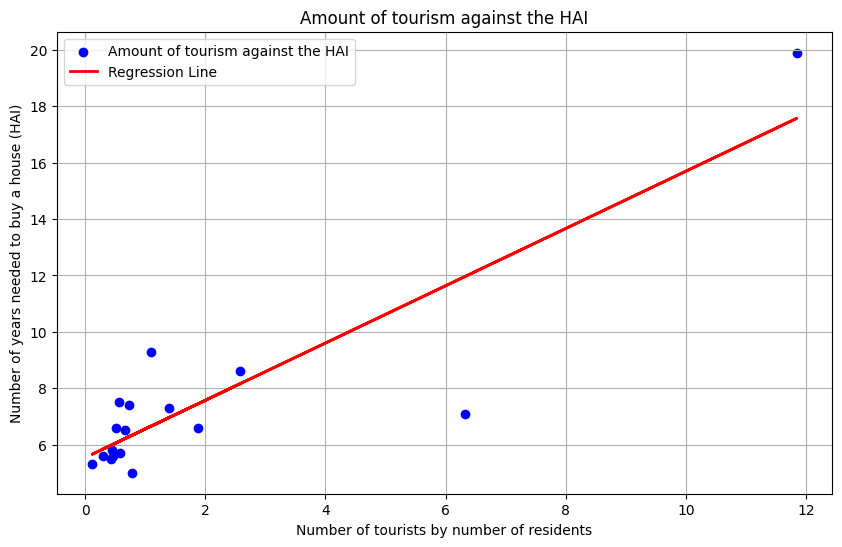

In [39]:
plt.figure(figsize=(10, 6))
plt.scatter(df4['Tourists ratio'], df4['HAI'], color='blue', label='Amount of tourism against the HAI')  
plt.plot(df4['Tourists ratio'], y_pred, color='red', linewidth=2, label='Regression Line')  

plt.xlabel('Number of tourists by number of residents')
plt.ylabel('Number of years needed to buy a house (HAI)')
plt.title('Amount of tourism against the HAI')
plt.legend()
plt.grid(True)

plt


While this R$^2$ of the linear model is relatively close to 1, suggesting that the model performs reasonably well, there's not enough data points to conclude anything. 

### Tourism against RAI

Similarly, we check if the relation between the ratio of tourists over residents and the RAI is linear.

In [40]:
X=map_df[['Tourists ratio']].values.reshape(-1, 1)
y=map_df['Salary_rent'].values

We make a linear regression object and fit it to the data

In [41]:
mdl = LinearRegression()
mdl.fit(X,y)

LinearRegression()

We predict the y coordinates given the x coordinates (tourists ratio) with our model.

In [42]:
y_pred = mdl.predict(X)

We evaluate the model's performance.

In [43]:
r2_score(y, y_pred)

0.5364447775602807

We now plot the model with the data points.

<module 'matplotlib.pyplot' from '/home/hjriera/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

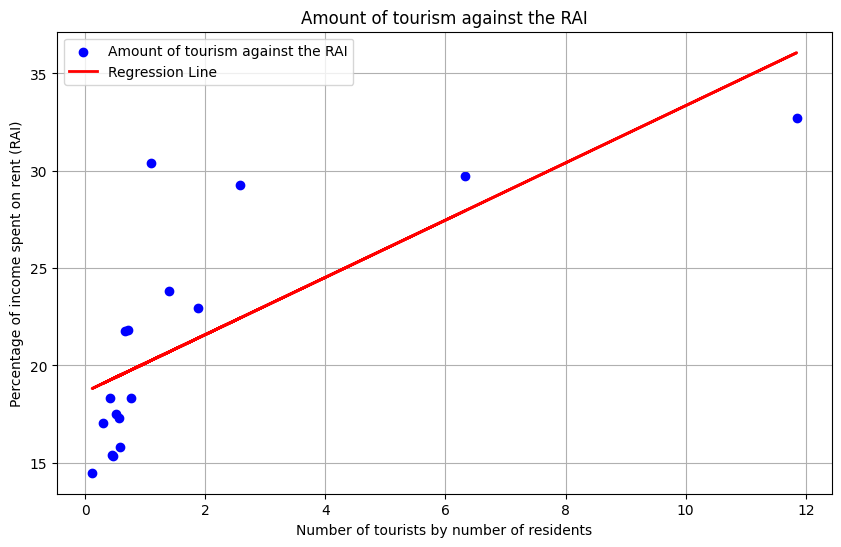

In [44]:
plt.figure(figsize=(10, 6))
plt.scatter(map_df['Tourists ratio'], map_df['Salary_rent'], color='blue', label='Amount of tourism against the RAI')  
plt.plot(map_df['Tourists ratio'], y_pred, color='red', linewidth=2, label='Regression Line') 

plt.xlabel('Number of tourists by number of residents')
plt.ylabel('Percentage of income spent on rent (RAI)')
plt.title('Amount of tourism against the RAI')
plt.legend()
plt.grid(True)

plt

A linear regression is not a good model, but we can see that a polynomial regression will do much better.

## 5.2 Polynomial regression

### Tourism against HAI

We now try a polynomial regression instead. We start by creating a polynomial features object.

In [45]:
from sklearn.preprocessing import PolynomialFeatures

X = map_df[['Tourists ratio']].values  
y = map_df[['HAI']].values    

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

We now fit the model to the data.

In [46]:
model = LinearRegression()
model.fit(X_poly, y)

LinearRegression()

We predict y-values.

In [47]:
y_pred = model.predict(X_poly)

We compute R$^2$.

In [48]:
r2 = r2_score(y, y_pred)

print(f"R^2: {r2:.4f}")

R^2: 0.8529


This score is better than the 0.77 for the linear model. We plot the result.

<module 'matplotlib.pyplot' from '/home/hjriera/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

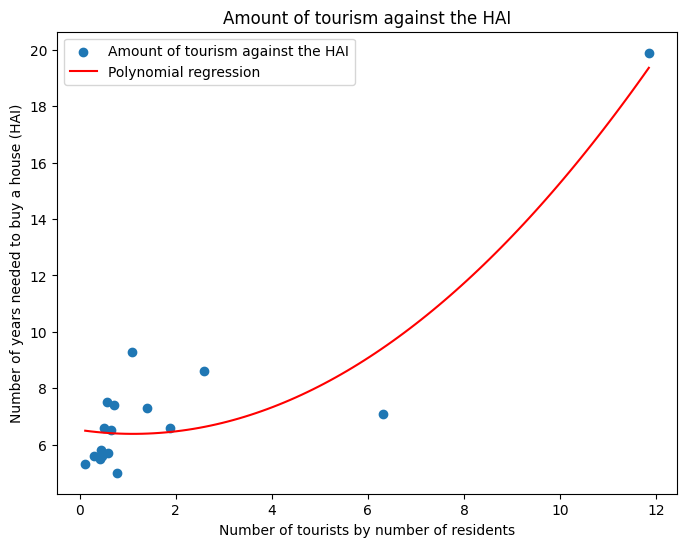

In [49]:
plt.figure(figsize=(8, 6))
plt.scatter(X, y, label='Amount of tourism against the HAI')

X_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X_line_poly = poly.transform(X_line)
y_line = model.predict(X_line_poly)

plt.plot(X_line, y_line, color='red', label='Polynomial regression')

plt.xlabel('Number of tourists by number of residents')
plt.ylabel('Number of years needed to buy a house (HAI)')
plt.title('Amount of tourism against the HAI')
plt.legend()

plt


This model is somewhat better than the linear model.

### Tourism against RAI

Similarly, we try a polynomial regression to model our tourism and RAI data. We start by creating a polynomial features object of degree two.

In [50]:
X = map_df[['Tourists ratio']].values  
y = map_df[['Salary_rent']].values     

poly = PolynomialFeatures(degree=2)

We transform X to include powers of the values in X up to degree 2.

In [51]:
X_poly = poly.fit_transform(X)

Now we apply a multiple linear regression with all the powers of X.

In [52]:
model = LinearRegression()
model.fit(X_poly, y)

LinearRegression()

We predict the y-values.

In [53]:
y_pred = model.predict(X_poly)

We compute the R$^2$ value

In [54]:
r2 = r2_score(y, y_pred)

print(f"R^2: {r2:.4f}")

R^2: 0.6983


This score is much better than the 0.52 from the linear model. We plot the result.

<module 'matplotlib.pyplot' from '/home/hjriera/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

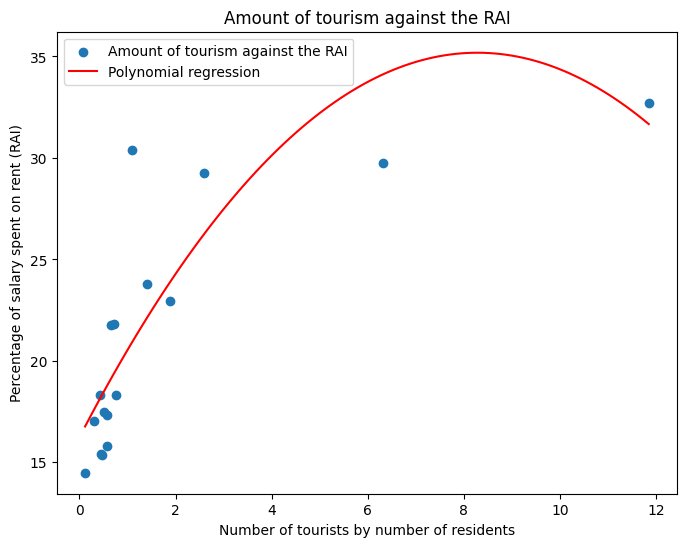

In [55]:
plt.figure(figsize=(8, 6))
plt.scatter(X, y, label='Amount of tourism against the RAI')

X_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X_line_poly = poly.transform(X_line)
y_line = model.predict(X_line_poly)

plt.plot(X_line, y_line, color='red', label='Polynomial regression')

plt.xlabel('Number of tourists by number of residents')
plt.ylabel('Percentage of salary spent on rent (RAI)')
plt.title('Amount of tourism against the RAI')
plt.legend()

plt


This model fits the data much better than the linear model.

## 5.3 Testing

Since the polynomial model performed much better than the linear model, in this section we explore the polynomial model further.

### Tourism against RAI

We split our data into training and testing.

In [56]:
X = map_df[['Tourists ratio']].values  
y = map_df[['Salary_rent']].values   

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

We create a polynomial features object and we transform X_train and X_test to include their powers.

In [57]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

We now list some values of alpha and perform ridge regression with each alpha. We then compute R$^2$ and store the alpha with the highest score.

In [58]:
from sklearn.linear_model import Ridge

#we list some values of alpha for ridge regression
alpha_values = [0.1, 1, 2,3,4,5,6,7,10,15]

#we initialise best_alpha and best_r2
best_alpha = None
best_r2 = -np.inf

#we loop through the list of alpha values 
for alpha in alpha_values:

    #we create a ridge regression model with each alpha
    model = Ridge(alpha=alpha)

    #we fit the model to the transformed training data
    model.fit(X_train_poly, y_train)

    #we predict the y values of both the training and the testing data
    y_test_pred = model.predict(X_test_poly)
    y_train_pred = model.predict(X_train_poly)

    #we compute R^2 with both the training and the testing data.
    test_r2 = r2_score(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    #we compute the avarage of both scores
    avg_r2=(test_r2+train_r2)/2

    #we update the best_r2 and best_alpha
    if avg_r2 > best_r2:
        best_r2 = avg_r2
        best_alpha = alpha
       
best_alpha

3

We now do a ridge regression with the best alpha.

In [59]:
model = Ridge(alpha=best_alpha) 
model.fit(X_train_poly, y_train)

Ridge(alpha=3)

We predict the y-values.

In [60]:
y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)

We evaluate the model by computing R^2, MSE, and RMSE.

In [61]:
print("Training set performance:")
print(f"R-squared: {r2_score(y_train, y_train_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_train, y_train_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.3f}")

print("\nTest set performance:")
print(f"R-squared: {r2_score(y_test, y_test_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_test_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.3f}")

Training set performance:
R-squared: 0.654
Mean Squared Error: 12.602
Root Mean Squared Error: 3.550

Test set performance:
R-squared: 0.691
Mean Squared Error: 8.307
Root Mean Squared Error: 2.882


We now plot the regression.

<module 'matplotlib.pyplot' from '/home/hjriera/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

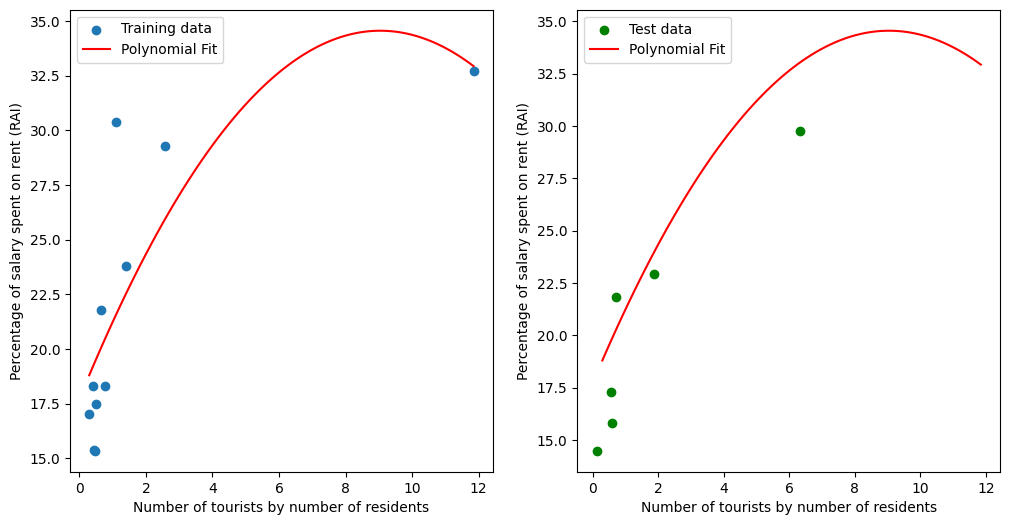

In [62]:
X_line = np.linspace(X_train.min(), X_train.max(), 100).reshape(-1, 1)
X_line_poly = poly.transform(X_line)
y_line = model.predict(X_line_poly)

#Training data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_train, y_train, label='Training data')
plt.plot(X_line, y_line, color='red', label='Polynomial Fit')
plt.xlabel('Number of tourists by number of residents')
plt.ylabel('Percentage of salary spent on rent (RAI)')
plt.legend()


#Testing data
plt.subplot(1, 2, 2)
plt.scatter(X_test, y_test, color='green', label='Test data')
plt.plot(X_line, y_line, color='red', label='Polynomial Fit')
plt.xlabel('Number of tourists by number of residents')
plt.ylabel('Percentage of salary spent on rent (RAI)')
plt.legend()

plt



The model performs reasonably well, even with unseen data. 

### Tourism against HAI

We split our data into training and testing.

In [63]:
X = map_df[['Tourists ratio']].values  
y = map_df[['HAI']].values   

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

We create a polynomial features object and we transform X_train and X_test to include their powers.

In [64]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

We now list some values of alpha and perform ridge regression with each alpha. We then compute R$^2$ and store the alpha with the highest score.

In [65]:
from sklearn.linear_model import Ridge

#we list some values of alpha for ridge regression
alpha_values = [0.1, 1, 2,7,15, 20, 30, 100, 1000, 10000, 100000]

#we initialise best_alpha and best_r2
best_alpha = None
best_r2 = -np.inf

#we loop through the list of alpha values 
for alpha in alpha_values:

    #we create a ridge regression model with each alpha
    model = Ridge(alpha=alpha)

    #we fit the model to the transformed training data
    model.fit(X_train_poly, y_train)

    #we predict the y values of both the training and the testing data
    y_test_pred = model.predict(X_test_poly)
    y_train_pred = model.predict(X_train_poly)

    #we compute R^2 with both the training and the testing data.
    test_r2 = r2_score(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    #we compute the avarage of both scores
    avg_r2=(test_r2+train_r2)/2

    #we update the best_r2 and best_alpha
    if avg_r2 > best_r2:
        best_r2 = avg_r2
        best_alpha = alpha
       
best_alpha

10000

In [66]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)

# Fit the polynomial regression model
model = Ridge(alpha=best_alpha)
model.fit(X_train_poly, y_train)

Ridge(alpha=10000)

In [67]:
X_test_poly = poly.transform(X_test)

# Predict values
y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)

# Evaluate the model
print("Training set performance:")
print(f"R-squared: {r2_score(y_train, y_train_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_train, y_train_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.3f}")

print("\nTest set performance:")
print(f"R-squared: {r2_score(y_test, y_test_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_test_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.3f}")

Training set performance:
R-squared: 0.793
Mean Squared Error: 3.290
Root Mean Squared Error: 1.814

Test set performance:
R-squared: 0.028
Mean Squared Error: 1.814
Root Mean Squared Error: 1.347


The model is overfit to the training data, it performs very well on the training data but very poorly on the testing data.

<module 'matplotlib.pyplot' from '/home/hjriera/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

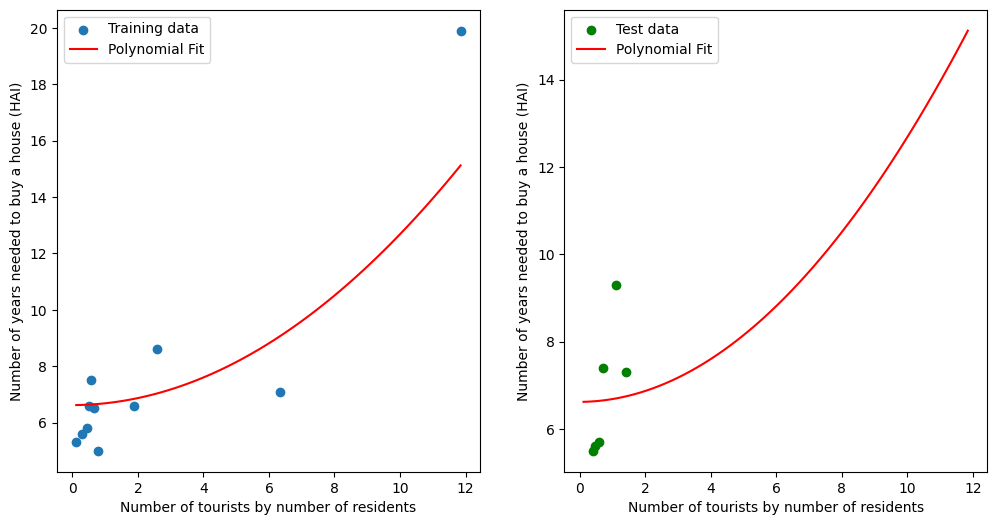

In [68]:
X_line = np.linspace(X_train.min(), X_train.max(), 100).reshape(-1, 1)
X_line_poly = poly.transform(X_line)
y_line = model.predict(X_line_poly)

#Training data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_train, y_train, label='Training data')
plt.plot(X_line, y_line, color='red', label='Polynomial Fit')
plt.xlabel('Number of tourists by number of residents')
plt.ylabel('Number of years needed to buy a house (HAI)')
plt.legend()

#Testing data
plt.subplot(1, 2, 2)
plt.scatter(X_test, y_test, color='green', label='Test data')
plt.plot(X_line, y_line, color='red', label='Polynomial Fit')
plt.xlabel('Number of tourists by number of residents')
plt.ylabel('Number of years needed to buy a house (HAI)')
plt.legend()

plt



Training set performance:
R-squared: 0.917
Mean Squared Error: 1.324
Root Mean Squared Error: 1.151

Test set performance:
R-squared: -0.283
Mean Squared Error: 2.395
Root Mean Squared Error: 1.548


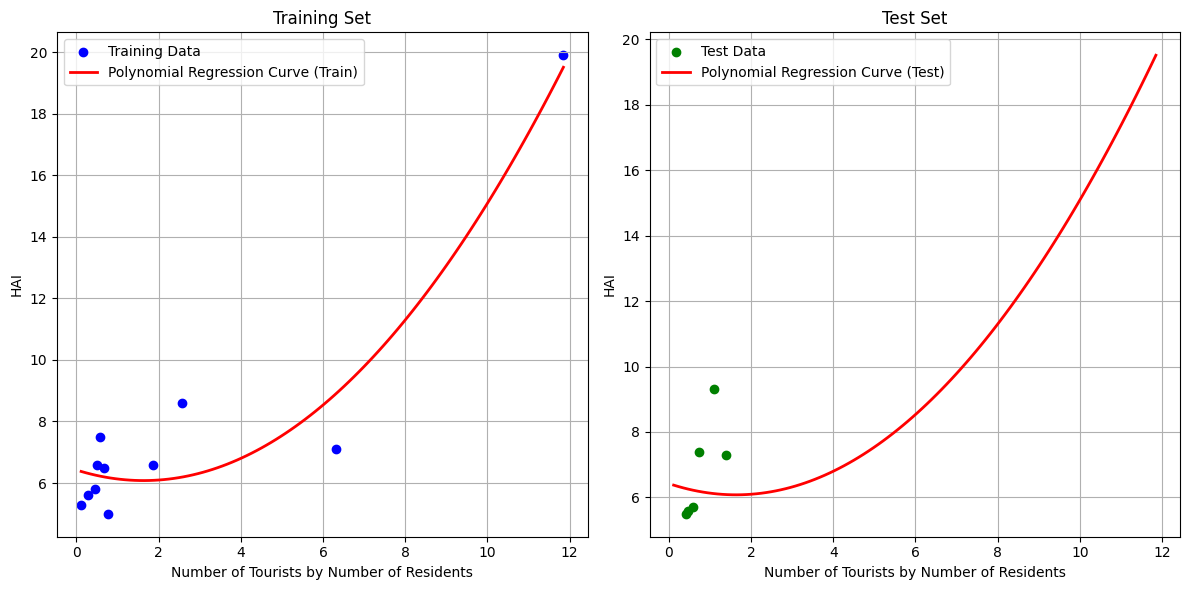

In [69]:

# Split data into training and test sets with a different random_state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Transform features to include polynomial terms
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Fit the polynomial regression model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Generate a range of values for a smooth curve
X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X_range_poly = poly.transform(X_range)
y_range_pred = model.predict(X_range_poly)

# Predict values for test data
y_test_pred = model.predict(X_test_poly)

# Evaluate the model
print("Training set performance:")
print(f"R-squared: {r2_score(y_train, model.predict(X_train_poly)):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_train, model.predict(X_train_poly)):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train, model.predict(X_train_poly))):.3f}")

print("\nTest set performance:")
print(f"R-squared: {r2_score(y_test, y_test_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_test_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.3f}")

# Plot the results
plt.figure(figsize=(12, 6))

# Plot training data and polynomial curve
plt.subplot(1, 2, 1)
plt.scatter(X_train, y_train, color='blue', label='Training Data')
plt.plot(X_range, y_range_pred, color='red', linewidth=2, label='Polynomial Regression Curve (Train)')
plt.xlabel('Number of Tourists by Number of Residents')
plt.ylabel('HAI')
plt.title('Training Set')
plt.legend()
plt.grid(True)

# Plot test data and polynomial curve
plt.subplot(1, 2, 2)
plt.scatter(X_test, y_test, color='green', label='Test Data')
plt.plot(X_range, y_range_pred, color='red', linewidth=2, label='Polynomial Regression Curve (Test)')
plt.xlabel('Number of Tourists by Number of Residents')
plt.ylabel('HAI')
plt.title('Test Set')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 4. Conclusions and further work

Initially, the polynomial model of the relation between HAI and tourism performed better than that of the relation between RAI and tourism, the first scoring 0.8529 and the second 0.6983 on the R^2 score. However, after performing a train test split and using a ridge regression model with a well-chosen alpha, the polynomial model performed better on the testing set corresponding to RAI than to HAI. This means our model for HAI was more overfit to the training data. 

Back to the original questions, this data gives some evidence that there is a monotonic quadratic relation between RAI and tourism. It also suggests a non-decreasing monotonic relation between HAI and tourism, but a weaker one. However, we can't conclude anything with much confidence due to the reduced data size. 

I'm currently working on exploring the same questions but using municipalities and provinces instead of 'autonomous communities'. This would solve the problem of having few data points. However, the relevant data, such as the average salary per municipality, is not easily available.